# Consigna TP3

Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en
Material_TPs / images a partir del template Material_TPs / template

<b> Parte 1 </b> <br>
4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos

<b> Parte 2: </b> <br>
4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen
coca_multi png con el mismo témplate del item 2

<b> Parte 3: </b> <br>
2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes
Visualizar
los resultados con bounding boxes en cada imagen mostrando el nivel de confianza
de la detección


In [15]:
#Si queremos que las imágenes sean mostradas en una ventana emergente descomentar el inline
# %matplotlib

import numpy as np  # OpenCV-Python utiliza NumPy para el manejo de imágenes
import cv2 as cv    # cv2 es el módulo python para acceder a OpenCV 
import matplotlib.pyplot as plt # Usamos las poderosas herramientas de graficación de matplotlib para mostrar imágenes, perfiles, histogramas, etc
import os



# Parte 1

## Cargo imagenes

Text(0.5, 1.0, 'Template - Canny')

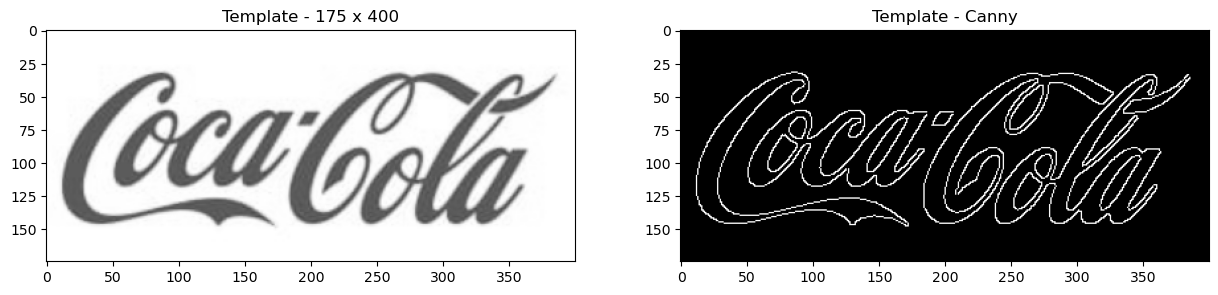

In [34]:
template = cv.imread("template/pattern.png")
template = cv.cvtColor(template, cv.COLOR_BGR2GRAY)
tH, tW = template.shape[:2]
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(cv.cvtColor(template, cv.COLOR_BGR2RGB))
plt.title(f'Template - {template.shape[0]} x {template.shape[1]}')
# Ahora extraigo los bordes exclusivamente
plt.subplot(1,2,2)
template = cv.Canny(template, 20, 205)
plt.imshow(cv.cvtColor(template, cv.COLOR_BGR2RGB))
plt.title('Template - Canny')

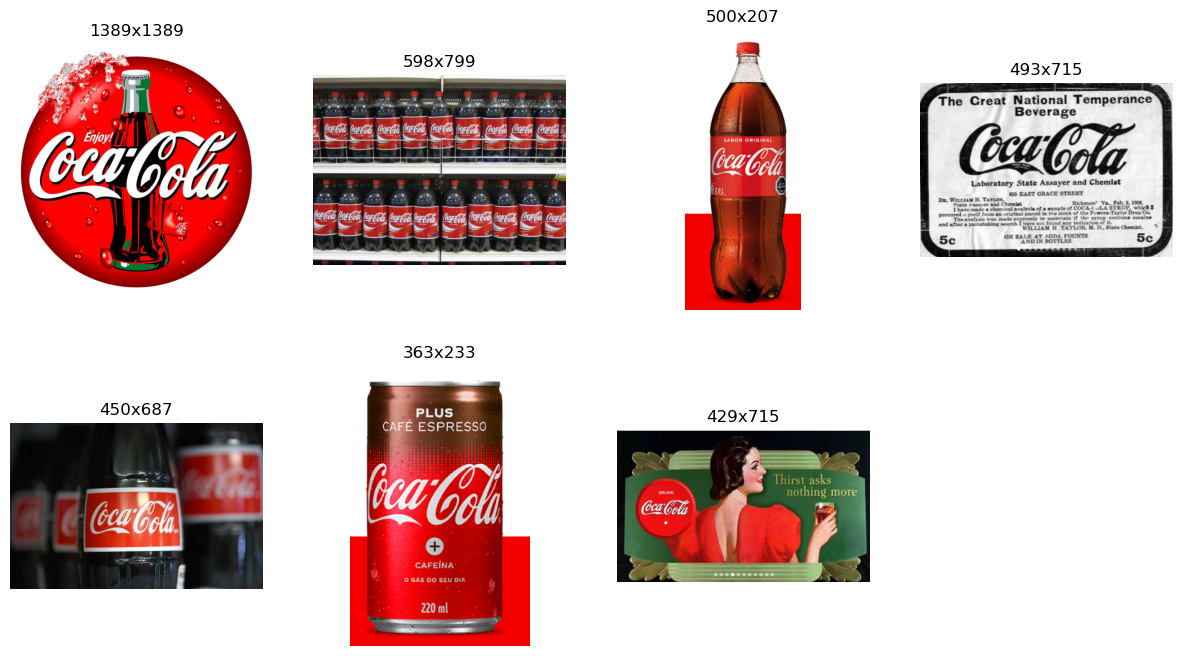

In [33]:
# Ahora veamos las imagenes donde hay que identificar los logos
path_img_dir = 'images'
path_imgs = os.listdir(path_img_dir) # 7 imagenes

imgs=[]
plt.figure(figsize=(15,8))
for i in range(len(path_imgs)):
    imgs.append(cv.imread(os.path.join(path_img_dir,path_imgs[i])))
    plt.subplot(2,4,i+1)
    plt.imshow(cv.cvtColor(imgs[i], cv.COLOR_BGR2RGB))
    plt.title(f'{imgs[i].shape[0]}x{imgs[i].shape[1]}')
    plt.axis('off')


In [77]:
# Podemos ver que las imagenes son en algunos casos más grandes y en otros más chicos que el template. 
# Por esta razón, armaremos una pirámide de templates de distinto tamaño para intentera matchear con el logo de cada imagen.
# Trabajamos con variaciones del template ya que esto es más eficiente si se quiere trabajar con multiples imagenes target.

# Creamos pirámide de templates
min_template_w = 50      # px template min width
max_template_w = 1400    # px template max width
pirmd = []
min_linsp = min_template_w/tW
max_linsp = max_template_w/tW
for i in np.linspace(min_linsp, max_linsp, 5):
    resized = cv.resize(template, (int(tW*i), int(tH*i)), interpolation = cv.INTER_AREA)
    pirmd.append(resized)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


breaking on 4


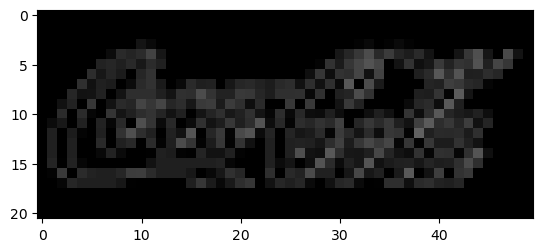

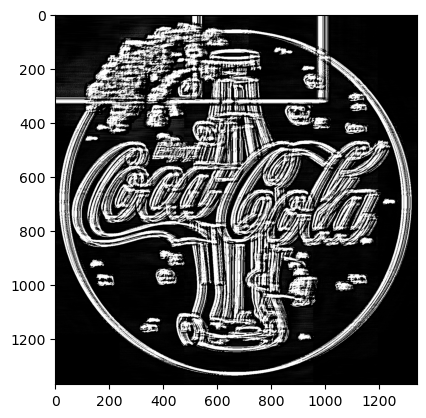

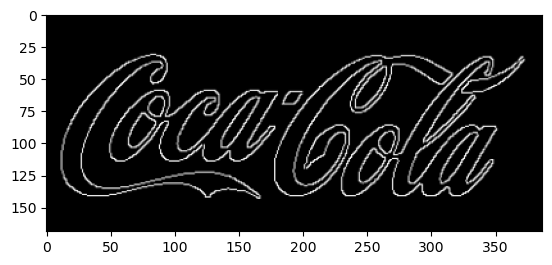

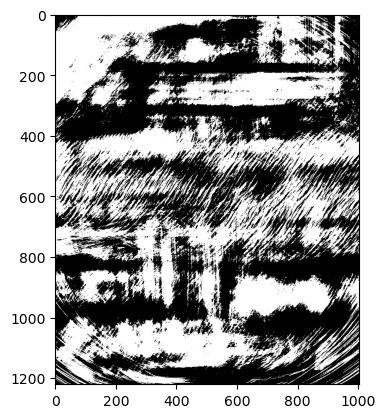

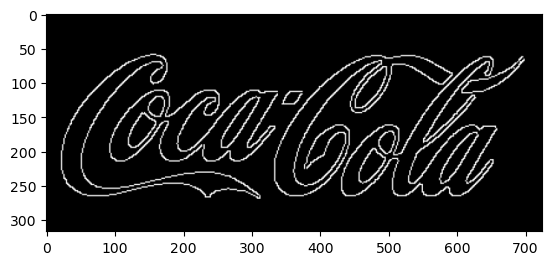

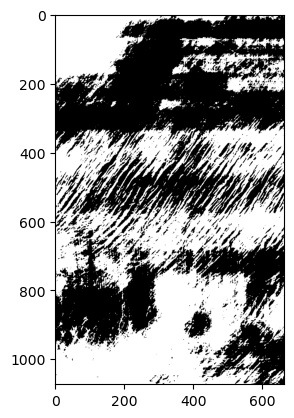

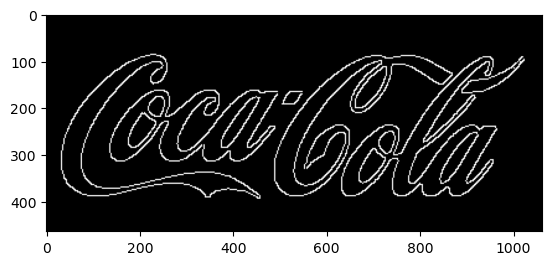

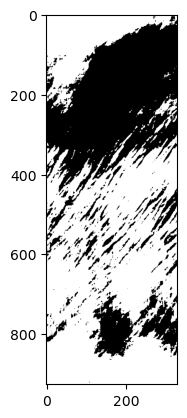

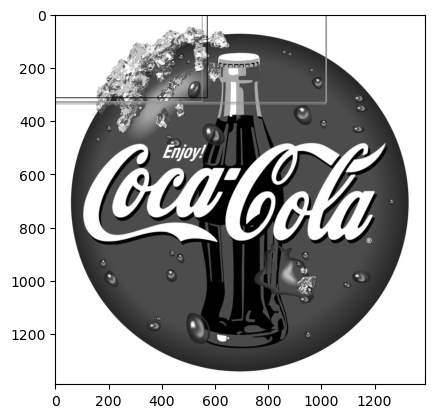

In [87]:
def Plot(img):
    plt.figure()
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

# Ahora hacemos template matching con la piramide para cada imagen target.
canny_th1 = 100
canny_th2 = 200
method = cv.TM_CCOEFF

match_vals = []
match_locs = []
for i in range(len(imgs)-6):
    target = imgs[i]
    h_target, w_target = target.shape[:2]
    if(w_target < min_template_w):  # Quick size filter
        continue   # Si el width de target es menor al minimo del template, lo salteamos

    match_vals.append([])
    match_locs.append([])
    target = cv.cvtColor(target, cv.COLOR_BGR2GRAY)
    edged = cv.Canny(target, canny_th1, canny_th2)
    k = 0
    h_src, w_src = (0,0)
    for src in pirmd:   # para cada template...
        h_src, w_src = src.shape[:2]
        if(h_target < h_src or w_target < w_src):
            print(f'breaking on {k}')
            continue
        k+=1
        res = cv.matchTemplate(src, edged, method)
        Plot(src)
        Plot(res)
    
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
        match_vals[i].append(max_val)
        match_locs[i].append(max_loc)
        # print(max_val, max_loc)

    # print('Max', i, ': ', max(match_vals[i]))

    # Ahora, para cada imagen, obtengo el indice de la mejor coincidencia
    idx = np.argmax(match_vals[i])

    # Dibujo el roi en la imagen target
    h_src, w_src = pirmd[idx].shape[:2]
    Yc, Xc = match_locs[i][idx]
    (Xo, Yo) = (int(Xc-w_src/2), int(Yc-h_src/2))
    (Xf, Yf) = (int(Xc+w_src/2), int(Yc+h_src/2))
    cv.rectangle(target, (Xo, Yo), (Xf, Yf), (0, 255, 0), 2)
    plt.figure()
    plt.imshow(cv.cvtColor(target, cv.COLOR_BGR2RGB))
